# STONKS
Predicting stock price using TimeSeriesGenerator

### importing libraries

In [1]:
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
from keras import models, layers
import yfinance as yf
import matplotlib.pyplot as plt

### Apple's Stock Data

In [2]:
# AAPL -- Apple's ticker
apple = yf.Ticker('AAPL')

### data frame

In [3]:
history = apple.history(period='max', interval='1d')

In [4]:
history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.100266,0.100702,0.100266,0.100266,469033600,0.0,0.0
1980-12-15,0.095470,0.095470,0.095035,0.095035,175884800,0.0,0.0
1980-12-16,0.088495,0.088495,0.088059,0.088059,105728000,0.0,0.0
1980-12-17,0.090239,0.090675,0.090239,0.090239,86441600,0.0,0.0
1980-12-18,0.092855,0.093291,0.092855,0.092855,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2020-12-02,122.019997,123.370003,120.889999,123.080002,89004200,0.0,0.0
2020-12-03,123.519997,123.779999,122.209999,122.940002,78967600,0.0,0.0
2020-12-04,122.599998,122.860001,121.519997,122.250000,78260400,0.0,0.0


### function that uses TimeseriesGenerator class with information about dividends

In [5]:
def generate_series(data, value_num):
    close = data['Close']
    dividends = data['Dividends']
    tsg = TimeseriesGenerator(close, close,
                              length=value_num,
                              batch_size=len(close))
    global_index = value_num
    i, t = tsg[0]
    has_dividends = np.zeros(len(i))
    for b_row in range(len(t)):
        assert(abs(t[b_row] - close[global_index]) <= 0.001)
        has_dividends[b_row] = dividends[global_index] > 0            
        global_index += 1
    return np.concatenate((i, np.transpose([has_dividends])),
                           axis=1), t

### performing MinMax normalization

In [6]:
h_min = history.min()
normalized_h = (history - h_min) / (history.max() - h_min)

### creates a neural network with a specified number of inputs

In [7]:
def create_model(n):
    m = models.Sequential()
    m.add(layers.Dense(64, activation='relu', input_shape=(n+1,)))
    m.add(layers.Dense(64, activation='relu'))
    m.add(layers.Dense(1))
    return m

### training the model

In [8]:
def select_inputs(data, start, end, epochs):
    models = {}
    for inputs in range(start, end+1):
        print('Using {} inputs'.format(inputs))
        model_inputs, targets = generate_series(data, inputs)
        
        train_inputs = model_inputs[:-1000]
        val_inputs = model_inputs[-1000:]
        train_targets = targets[:-1000]
        val_targets = targets[-1000:]
        
        m = create_model(inputs)
        print('Training')
        m.compile(optimizer='adam', loss='mse', metrics=['accuracy']) 
        h = m.fit(train_inputs, train_targets,
                  epochs=epochs,
                  batch_size=32,
                  validation_data=(val_inputs, val_targets))
        model_info = {'model': m, 'history': h.history}
        models[inputs] = model_info
    return models


In [9]:
trained_models = select_inputs(normalized_h, 2, 10, 10)

Using 2 inputs
Training
Epoch 1/10
284/284 [==============================] - 1s 5ms/step - loss: 2.2348e-04 - accuracy: 1.1012e-04 - val_loss: 0.0052 - val_accuracy: 0.0010
Epoch 2/10
284/284 [==============================] - 1s 3ms/step - loss: 2.3216e-06 - accuracy: 1.1012e-04 - val_loss: 0.0047 - val_accuracy: 0.0010
Epoch 3/10
284/284 [==============================] - 1s 3ms/step - loss: 1.5720e-06 - accuracy: 1.1012e-04 - val_loss: 0.0044 - val_accuracy: 0.0010
Epoch 4/10
284/284 [==============================] - 1s 4ms/step - loss: 1.9662e-06 - accuracy: 1.1012e-04 - val_loss: 0.0047 - val_accuracy: 0.0010
Epoch 5/10
284/284 [==============================] - 1s 4ms/step - loss: 2.0978e-06 - accuracy: 1.1012e-04 - val_loss: 0.0046 - val_accuracy: 0.0010
Epoch 6/10
284/284 [==============================] - 1s 4ms/step - loss: 4.6039e-06 - accuracy: 1.1012e-04 - val_loss: 0.0044 - val_accuracy: 0.0010
Epoch 7/10
284/284 [==============================] - 1s 4ms/step - loss: 1.

### short summary

In [14]:
model_stats = {}
for k, v in trained_models.items():
    train_history = v['history']
    loss = train_history['loss'][-1]
    val_loss = train_history['val_loss'][-1]
    accuracy = train_history['accuracy'][-1]
    model_stats[k] = {'inputs': k, 'loss': loss, 'val_loss': val_loss, 'accuracy': accuracy}

In [15]:
model_stats

{2: {'inputs': 2,
  'loss': 2.4785881578281987e-06,
  'val_loss': 0.004786770325154066,
  'accuracy': 0.00011012003233190626},
 3: {'inputs': 3,
  'loss': 2.7443195449450286e-06,
  'val_loss': 0.00027500325813889503,
  'accuracy': 0.0001101321613532491},
 4: {'inputs': 4,
  'loss': 2.106454985550954e-06,
  'val_loss': 0.000307499518385157,
  'accuracy': 0.00011014429037459195},
 5: {'inputs': 5,
  'loss': 7.245840606628917e-06,
  'val_loss': 0.00039000165998004377,
  'accuracy': 0.00011015641939593479},
 6: {'inputs': 6,
  'loss': 2.512232640583534e-06,
  'val_loss': 0.00031674656202085316,
  'accuracy': 0.00011016855569323525},
 7: {'inputs': 7,
  'loss': 3.943517640436767e-06,
  'val_loss': 0.00030297672492451966,
  'accuracy': 0.00011018069926649332},
 8: {'inputs': 8,
  'loss': 2.9877267024858156e-06,
  'val_loss': 0.0007042440702207386,
  'accuracy': 0.00011019283556379378},
 9: {'inputs': 9,
  'loss': 2.7024086648452794e-06,
  'val_loss': 0.0006374309887178242,
  'accuracy': 0.00

### plotting val loss

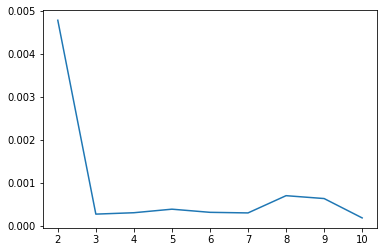

In [12]:
val_loss = []
indices = []
for k, v in model_stats.items():
    indices.append(k)
    val_loss.append(v['val_loss'])
plt.plot(indices, val_loss)

### actual loss

In [13]:
vals = []
close_min = history['Close'].min()
close_max = history['Close'].max()
for k in model_stats:
    e = ((close_max - close_min) * model_stats[k]['val_loss'] + close_min)
    vals.append(e)
    print(k, e)

2 0.6793615451307186
3 0.07518840001180607
4 0.0795399916312235
5 0.09058789761263861
6 0.0807782681985744
7 0.07893434193582725
8 0.1326682671230422
9 0.1237212915839421
10 0.06336526265412235
